In [1]:
# Create Adversarial Cross Sections like image below
# compare Classic vs FGNs (converted, quick retrain, deep retrain)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib as mpl
# set this 'backend' when using jupyter; do this before importing pyplot
mpl.use('nbagg')
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = (8.0, 6.0)

In [4]:
import numpy as np
import torch
from torch import optim
import copy

In [5]:
# custom library imports
import sys
sys.path.append('/home/felix/Research/Adversarial Research/FGN---Research/')
import Finite_Gaussian_Network_lib as fgnl
import Finite_Gaussian_Network_lib.fgn_helper_lib as fgnh

In [6]:
# check gpus
!gpustat

crescent                Mon Mar  1 21:39:14 2021  418.152.00
[0] GeForce RTX 2080 Ti | 28'C,   0 % |  4836 / 10989 MB | near(1305M) salami(907M) salami(909M) salami(853M) salami(851M)
[1] GeForce RTX 2080 Ti | 27'C,   0 % |    11 / 10989 MB |


In [7]:
# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
use_cuda = False
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")
print("Using device:", device)

# manualy set cuda device
# torch.cuda.set_device(1)

CUDA Available:  False
Using device: cpu


/home/felix/.local/lib/python3.6/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [8]:
# get data 
(mnist_train_loader, mnist_val_loader, mnist_test_loader) = fgnh.mnist_dataloaders(batch_size=10000, 
                                                                                   batch_size_for_val=10000)

In [9]:
# load classic model
classic_model_path = "../Experiments/sample_models/sample_classic_full.pth"
classic_model = torch.load(classic_model_path, map_location=torch.device(device))

In [10]:
# load an fgn model check same params as FGN
fgn_model_path = '../Experiments/sample_models/sample_FGN_full.pth'
conv_fgn_model = torch.load(fgn_model_path, map_location=torch.device(device))

In [11]:
# model params
!cat '../Experiments/sample_models/sample_FGN_parameters.txt'

hidden_layer_sizes [64, 64]
drop_p 0.2
batch_size 4000
optimizer Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.01
    weight_decay: 0
)
ordinal 2.0
covar_type sphere
lambda for l2 loss 8e-06
lambda for sigma loss 1e-06
non-linearity True


In [12]:
# # model from scratch
# hidden_layer_sizes = [64, 64]
# drop_p = 0.2
# ordinal = 3
# covar_type = 'diag'
# non_lin = True

# conv_fgn_model = fgnl.Feedforward_FGN_net(in_feats=28*28, out_feats=10,
#                                           hidden_layer_sizes = hidden_layer_sizes,
#                                           drop_p = drop_p,
#                                           ordinal = ordinal,
#                                           covar_type = covar_type,
#                                           non_lin = non_lin,
#                                           )

In [13]:
# convert model
fgnl.convert_classic_to_fgn(classic_model, conv_fgn_model, init_factor=1e2, verbose=True)

odict_keys([])

Classic odict_keys(['hidden_layers.1.weight', 'hidden_layers.1.bias', 'hidden_layers.2.weight', 'hidden_layers.2.bias', 'hidden_layers.2.running_mean', 'hidden_layers.2.running_var', 'hidden_layers.2.num_batches_tracked', 'hidden_layers.4.weight', 'hidden_layers.4.bias', 'hidden_layers.5.weight', 'hidden_layers.5.bias', 'hidden_layers.5.running_mean', 'hidden_layers.5.running_var', 'hidden_layers.5.num_batches_tracked', 'ib.weight', 'ib.bias', 'ib.running_mean', 'ib.running_var', 'ib.num_batches_tracked', 'fl.weight', 'fl.bias'])
FGN odict_keys(['hidden_layers.1.weights', 'hidden_layers.1.biases', 'hidden_layers.1.centers', 'hidden_layers.1.inv_covars', 'hidden_layers.2.weight', 'hidden_layers.2.bias', 'hidden_layers.2.running_mean', 'hidden_layers.2.running_var', 'hidden_layers.2.num_batches_tracked', 'hidden_layers.4.weights', 'hidden_layers.4.biases', 'hidden_layers.4.centers', 'hidden_layers.4.inv_covars', 'hidden_layers.5.weight', 'hidden_layers.5.bias', 'hidden_la

In [14]:
# do a quick retrain of the converted model
ret_quick_fgn_model = copy.deepcopy(conv_fgn_model)

# define loss
lmbda_l2 = (4.0*0.1/len(mnist_train_loader.dataset))
lmbda_sigs = 1e-5
print("lambda for l2 loss", lmbda_l2)
print("lambda for sigs^2 loss", lmbda_sigs)

cross_ent_loss = fgnl.def_fgn_cross_ent_loss(lmbda_l2, lmbda_sigs)

# define optimizer
optimizer = optim.Adam(filter(lambda p: p.requires_grad, ret_quick_fgn_model.parameters()), lr=1e-3)

# train the network for N epochs
epochs = 1
train_res = fgnh.train(ret_quick_fgn_model, mnist_train_loader, 
                             cross_ent_loss, optimizer, epochs, save_hist=2, verbose=True, 
                             pred_func=fgnh.cross_ent_pred_accuracy, test_loader=mnist_val_loader)

lambda for l2 loss 8e-06
lambda for sigs^2 loss 1e-05
Epoch 0 Train set - Average loss: 78.8275, Accuracy: 48363/50000 (97%)
Test set - Average loss: 1.0722, Accuracy: 9741/10000 (97%)


In [15]:
# load heavily retrained model
ret_long_fgn_model_path = '../Experiments/sample_models/sample_fgn_converted+retrained_full.pth'
ret_long_fgn_model = torch.load(ret_long_fgn_model_path, map_location=torch.device(device))
# ret_long_fgn_model.to(device)

# Preliminary: Verify accuracies and confidences

In [16]:
# make sure all the models perform well on MNIST

for m, name in zip([classic_model, conv_fgn_model, ret_quick_fgn_model, ret_long_fgn_model],
                   ['classic_model', 'conv_fgn_model', 'ret_quick_fgn_model', 'ret_long_fgn_model']):
    
    print('Results for {}'.format(name))
    # accuracies
    _ = fgnh.test(m, mnist_train_loader,
                     pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)
    _ = fgnh.test(m, mnist_val_loader,
                     pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)
    

Results for classic_model
Test set - Average loss: 0.0320, Accuracy: 49509/50000 (99%)
Test set - Average loss: 0.0934, Accuracy: 9739/10000 (97%)
Results for conv_fgn_model
Test set - Average loss: 0.0321, Accuracy: 49509/50000 (99%)
Test set - Average loss: 0.0934, Accuracy: 9739/10000 (97%)
Results for ret_quick_fgn_model
Test set - Average loss: 0.0294, Accuracy: 49561/50000 (99%)
Test set - Average loss: 0.0895, Accuracy: 9741/10000 (97%)
Results for ret_long_fgn_model
Test set - Average loss: 0.0174, Accuracy: 49739/50000 (99%)
Test set - Average loss: 0.0766, Accuracy: 9806/10000 (98%)


Results for classic_model


<IPython.core.display.Javascript object>


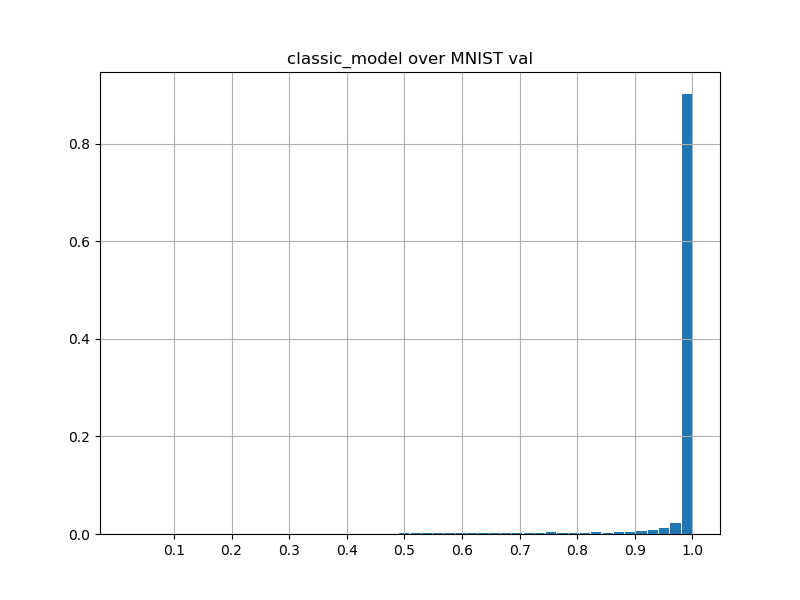

Statistical description of the predictions maximums
DescribeResult(nobs=10000, minmax=(0.29278902101341025934, 0.9999924622935616388), mean=0.9822352460104473712, variance=0.0049172545029777912165, skewness=-5.4000555320904229358, kurtosis=31.411600146563036437)

percentage of confident predictions (>=0.5): 0.9961

Sample predictions
index 3993 prediction [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
index 5551 prediction [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
index 3579 prediction [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
index 6145 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 902 prediction [0.   0.   0.   0.   0.   0.   0.   0.   0.99 0.  ]

Results for conv_fgn_model


<IPython.core.display.Javascript object>


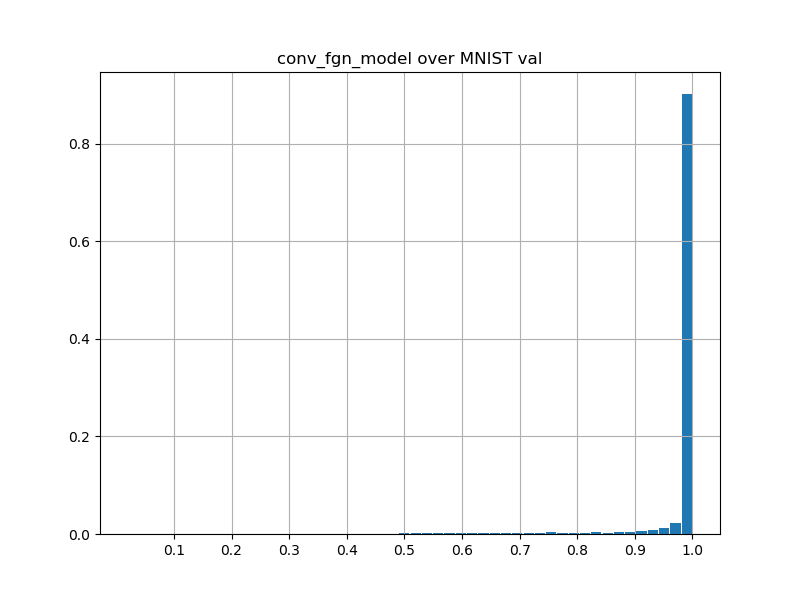

Statistical description of the predictions maximums
DescribeResult(nobs=10000, minmax=(0.29278965900470243423, 0.9999924488874125899), mean=0.98223236853703007156, variance=0.0049176073970886786305, skewness=-5.399276142372088843, kurtosis=31.400392817293748367)

percentage of confident predictions (>=0.5): 0.9961

Sample predictions
index 7162 prediction [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
index 8187 prediction [0.   0.   0.   0.   0.   0.   0.   0.05 0.   0.95]
index 5777 prediction [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
index 5112 prediction [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
index 7471 prediction [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

Results for ret_quick_fgn_model


<IPython.core.display.Javascript object>


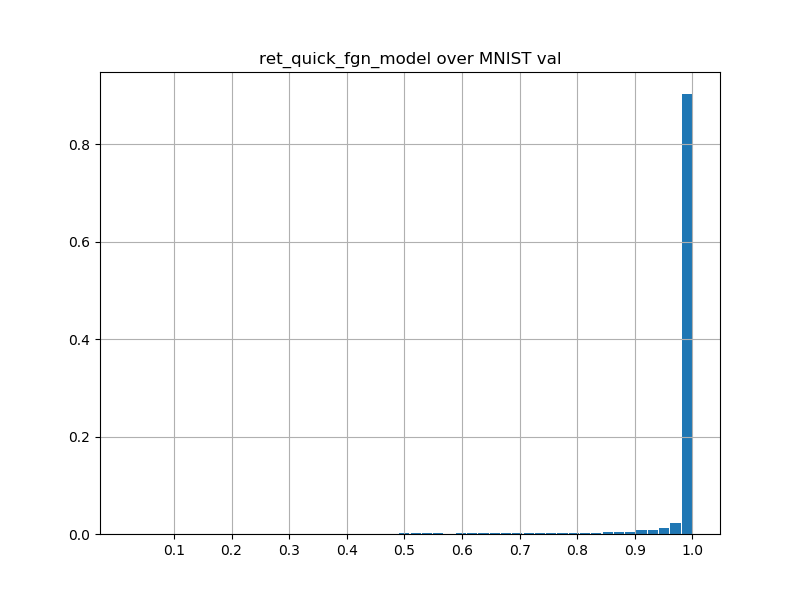

Statistical description of the predictions maximums
DescribeResult(nobs=10000, minmax=(0.16390959798024173411, 0.9999928463609796525), mean=0.98223466501108267146, variance=0.0050491102484673372055, skewness=-5.5504024466101997506, kurtosis=33.760776738871090645)

percentage of confident predictions (>=0.5): 0.9956

Sample predictions
index 394 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 825 prediction [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
index 6541 prediction [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
index 4975 prediction [0.   0.   0.   0.   0.   0.99 0.   0.   0.01 0.  ]
index 1063 prediction [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]

Results for ret_long_fgn_model


<IPython.core.display.Javascript object>


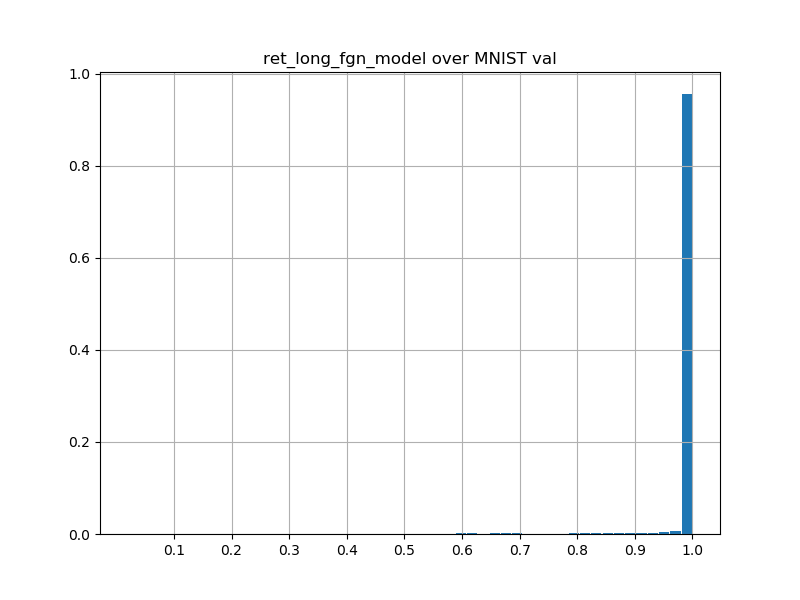

Statistical description of the predictions maximums
DescribeResult(nobs=10000, minmax=(0.1, 0.99999983932636181866), mean=0.99016408069698914706, variance=0.00369766197599524115, skewness=-8.410776888220885646, kurtosis=83.6409678074379577)

percentage of confident predictions (>=0.5): 0.9962

Sample predictions
index 5248 prediction [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
index 2037 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 7606 prediction [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
index 2630 prediction [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
index 8242 prediction [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]



In [17]:
for m, name in zip([classic_model, conv_fgn_model, ret_quick_fgn_model, ret_long_fgn_model],
                   ['classic_model', 'conv_fgn_model', 'ret_quick_fgn_model', 'ret_long_fgn_model']):
    
    print('Results for {}'.format(name))
    # confidences
    fgnh.plot_pred_histogram(m, mnist_val_loader, title='{} over MNIST val'.format(name) ,verbose=True)
    
    print()

# 1 - FGSM Hyperplanes

In [18]:
img = mnist_val_loader.dataset.tensors[0][700]
loss_func = torch.nn.CrossEntropyLoss()
epsilon = 1*0.013
grid_size = 150
mode = 'random'
n_plots = 4
min_pix = np.min(mnist_train_loader.dataset.tensors[0].numpy())
max_pix = np.max(mnist_train_loader.dataset.tensors[0].numpy())

<IPython.core.display.Javascript object>


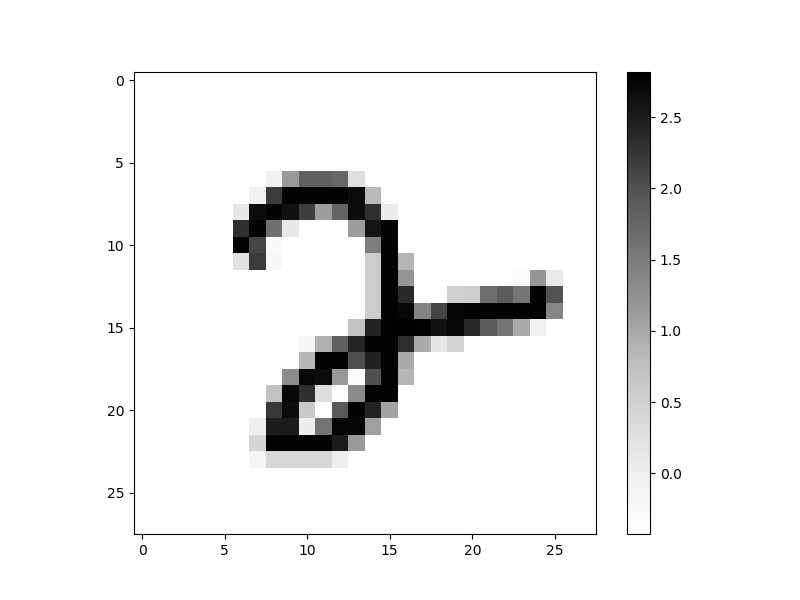

In [19]:
plt.imshow(img.numpy(), cmap='Greys', vmin=min_pix, vmax=max_pix)
plt.colorbar()
plt.show()

In [20]:
classic_fgsm_vec = fgnl.get_fgsm_attack_vectors(classic_model, img, loss_func)
random_noise = np.reshape(np.array([ np.random.choice([-1,0,1]) for _ in range(28*28)]), (28,28))

<IPython.core.display.Javascript object>


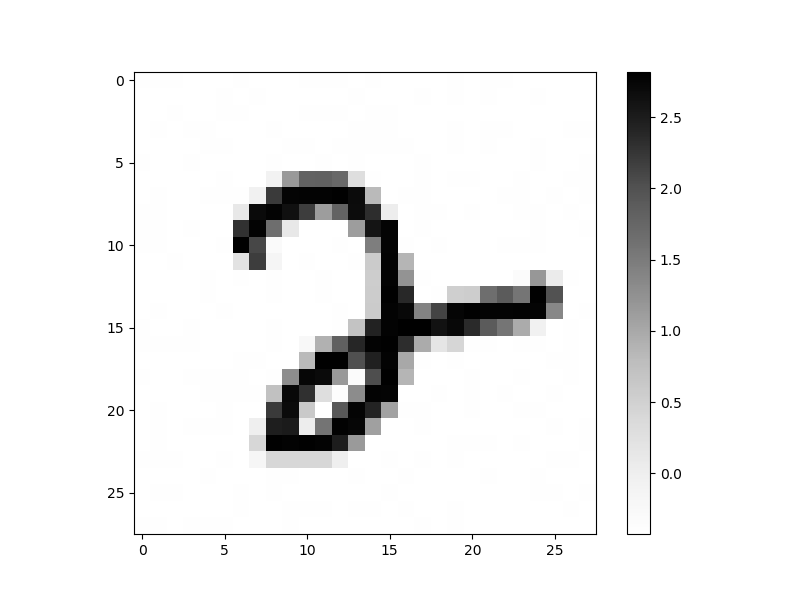

In [21]:
plt.imshow((img-epsilon*random_noise).numpy(), cmap='Greys', vmin=min_pix, vmax=max_pix)
plt.colorbar()
plt.show()

<IPython.core.display.Javascript object>


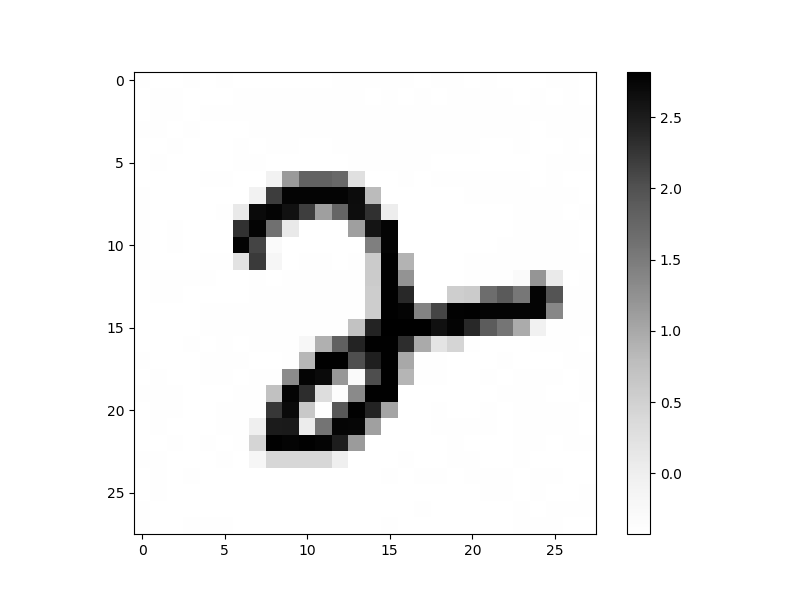

In [22]:
plt.imshow((img-epsilon*classic_fgsm_vec).numpy(), cmap='Greys', vmin=min_pix, vmax=max_pix)
plt.colorbar()
plt.show()

In [23]:
classic_model(img)

tensor([[-1.5652,  2.3307,  7.0773,  0.8582, -2.4727, -5.1305,  2.2491,  6.9516,
         -2.3226, -5.7803]], grad_fn=<AddmmBackward>)

In [24]:
classic_model(img-10*epsilon*classic_fgsm_vec)

tensor([[-5.2142,  2.9829,  3.9967,  2.3812,  0.3639,  3.0283, -1.3205,  4.4262,
         -6.1991, -1.3608]], grad_fn=<AddmmBackward>)

In [25]:
classic_model(img-epsilon*torch.Tensor(random_noise))

tensor([[-3.1930,  3.0350,  2.6039,  2.3188, -3.9338,  0.7373,  0.8779,  8.0428,
         -5.2223, -4.0895]], grad_fn=<AddmmBackward>)

<IPython.core.display.Javascript object>


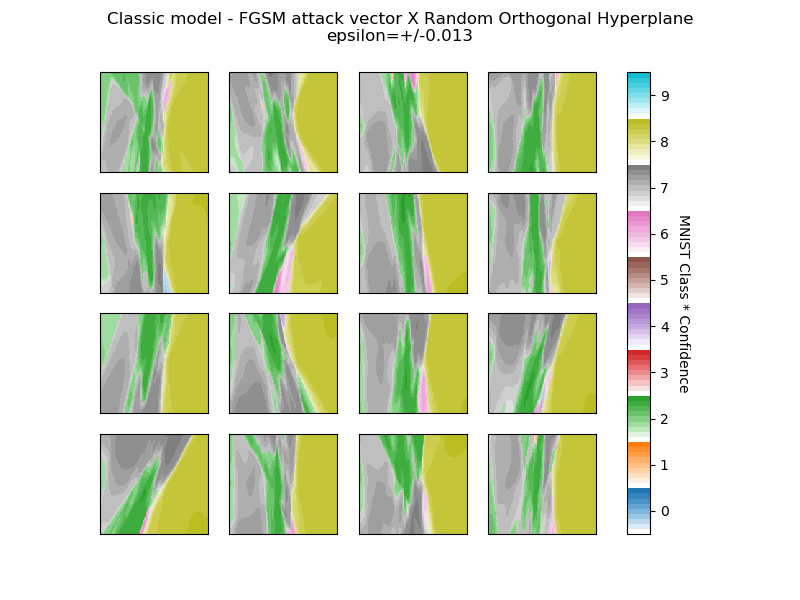

In [26]:
fgnh.plot_MNIST_hyperplanes(classic_model, img-epsilon*classic_fgsm_vec, img+epsilon*classic_fgsm_vec,
                            n_plots=n_plots, grid_size=grid_size, mode=mode,
                            title='Classic model - FGSM attack vector X Random Orthogonal Hyperplane\nepsilon=+/-{}'.format(epsilon))

<IPython.core.display.Javascript object>


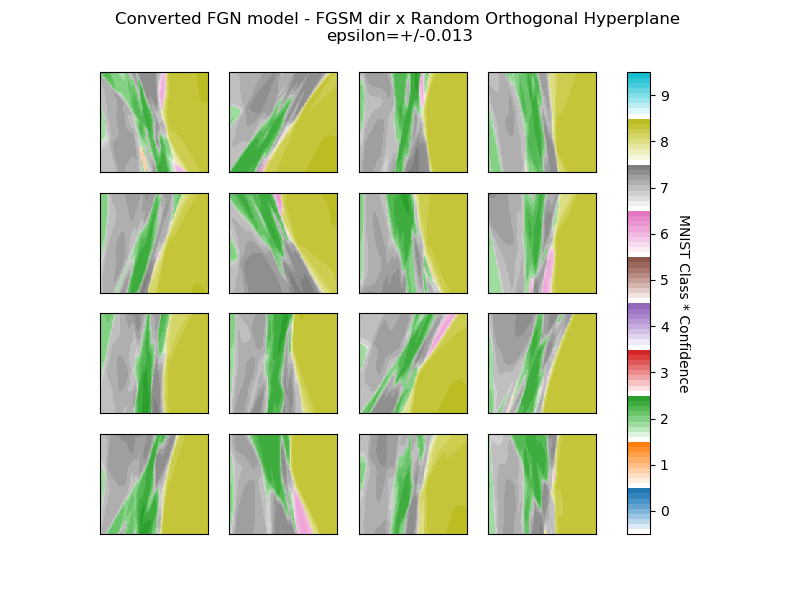

In [27]:
conv_fgn_fgsm_vec = fgnl.get_fgsm_attack_vectors(conv_fgn_model, img, loss_func)

fgnh.plot_MNIST_hyperplanes(conv_fgn_model, img-epsilon*conv_fgn_fgsm_vec, img+epsilon*conv_fgn_fgsm_vec, 
                            n_plots=n_plots, grid_size=grid_size, mode=mode,
                             title='Converted FGN model - FGSM dir x Random Orthogonal Hyperplane \nepsilon=+/-{}'.format(epsilon))

<IPython.core.display.Javascript object>


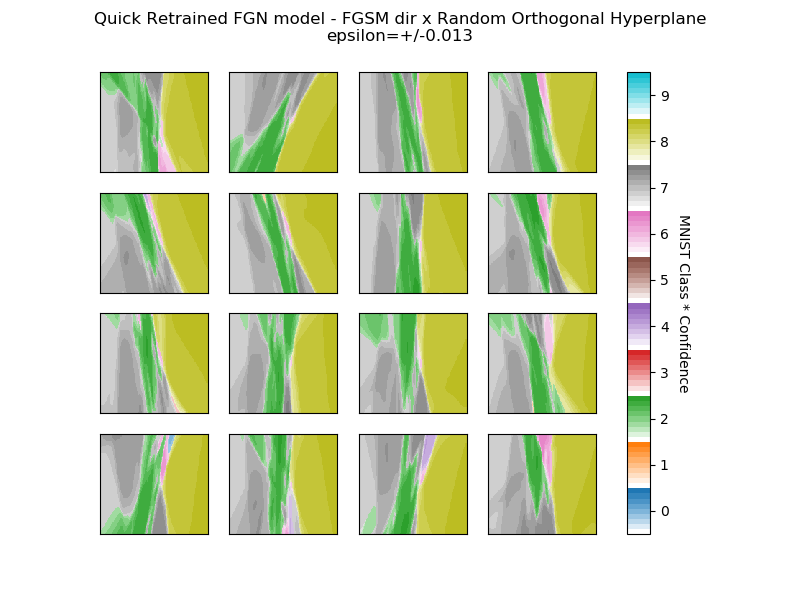

In [28]:
ret_quick_fgn_fgsm_vec = fgnl.get_fgsm_attack_vectors(ret_quick_fgn_model, img, loss_func)

fgnh.plot_MNIST_hyperplanes(ret_quick_fgn_model, img-epsilon*ret_quick_fgn_fgsm_vec, img+epsilon*ret_quick_fgn_fgsm_vec, 
                            n_plots=n_plots, grid_size=grid_size, mode=mode,
                        title='Quick Retrained FGN model - FGSM dir x Random Orthogonal Hyperplane\nepsilon=+/-{}'.format(epsilon))

<IPython.core.display.Javascript object>


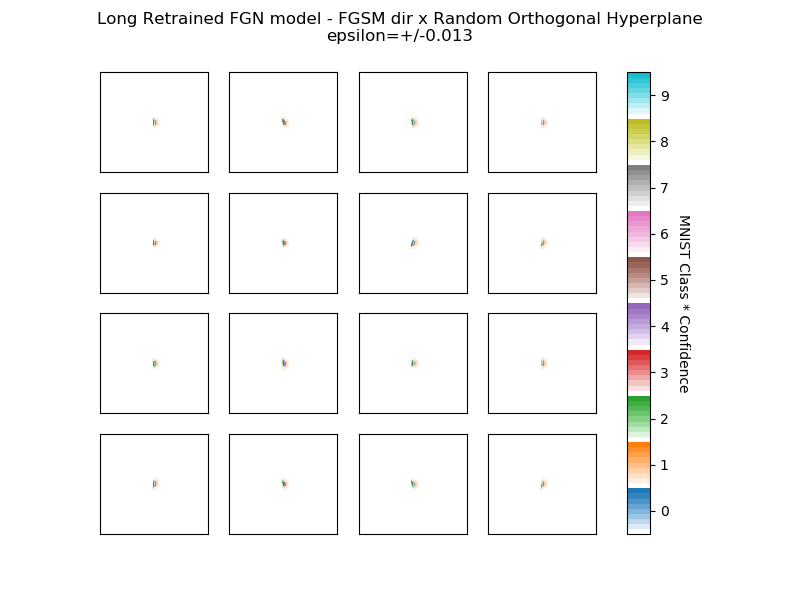

In [29]:
ret_long_fgn_fgsm_vec = fgnl.get_fgsm_attack_vectors(ret_long_fgn_model, img, loss_func)

fgnh.plot_MNIST_hyperplanes(ret_long_fgn_model, img-epsilon*ret_long_fgn_fgsm_vec, img+epsilon*ret_long_fgn_fgsm_vec, 
                            n_plots=n_plots, grid_size=grid_size, mode=mode,
                        title='Long Retrained FGN model - FGSM dir x Random Orthogonal Hyperplane\nepsilon=+/-{}'.format(epsilon))

<IPython.core.display.Javascript object>


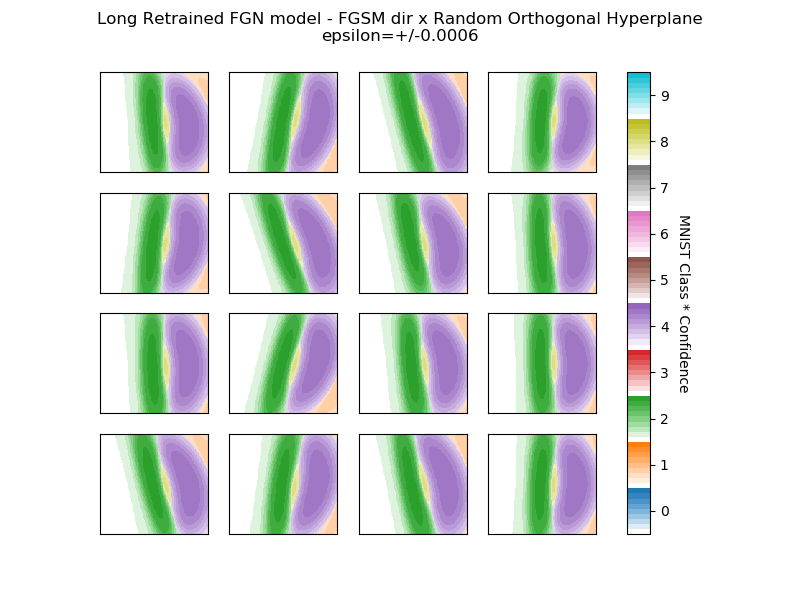

In [30]:
# zoom in
ret_long_fgn_fgsm_vec = fgnl.get_fgsm_attack_vectors(ret_long_fgn_model, img, loss_func)

factor = 0.05
fgnh.plot_MNIST_hyperplanes(ret_long_fgn_model, img-factor*epsilon*ret_long_fgn_fgsm_vec, img+factor*epsilon*ret_long_fgn_fgsm_vec, 
                            n_plots=n_plots, grid_size=grid_size, mode=mode,
                        title='Long Retrained FGN model - FGSM dir x Random Orthogonal Hyperplane\nepsilon=+/-{}'.format(np.around(factor*epsilon,4)))

# 2-Space between classes

In [31]:
img2 = mnist_val_loader.dataset.tensors[0][34]

loss_func = torch.nn.CrossEntropyLoss()
grid_size = 50

In [32]:
mnist_val_loader.dataset.tensors[1][0:40]

tensor([3, 8, 6, 9, 6, 4, 5, 3, 8, 4, 5, 2, 3, 8, 4, 8, 1, 5, 0, 5, 9, 7, 4, 1,
        0, 3, 0, 6, 2, 9, 9, 4, 1, 3, 6, 8, 0, 7, 7, 6])

<IPython.core.display.Javascript object>


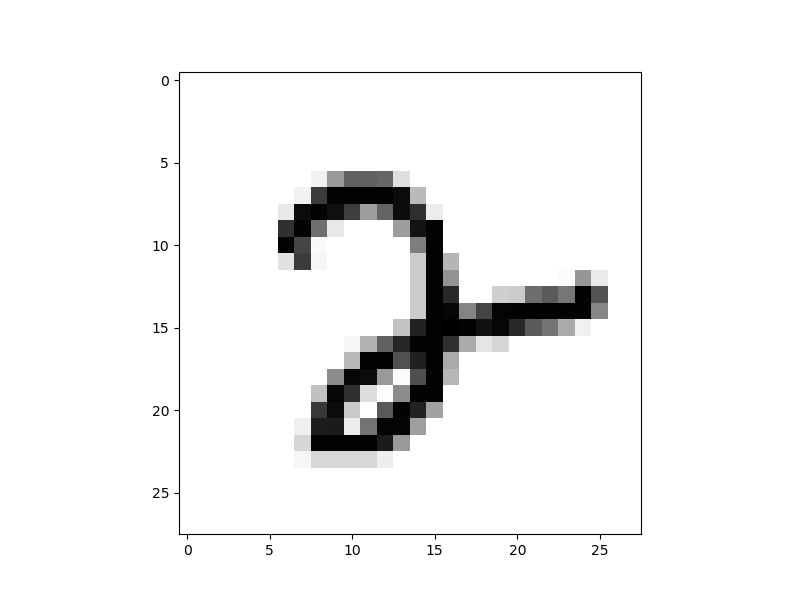

<IPython.core.display.Javascript object>


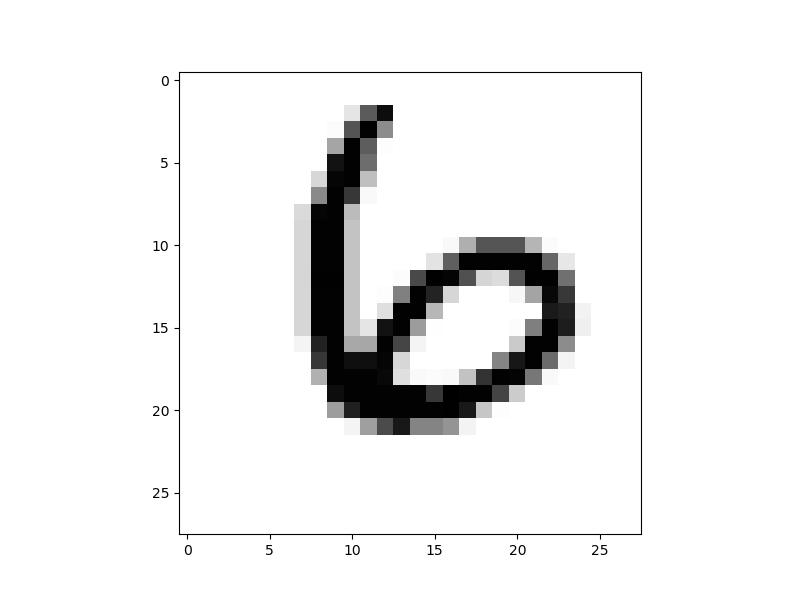

In [33]:
plt.imshow(img, cmap='Greys')
plt.show()
plt.imshow(img2, cmap='Greys')
plt.show()

<IPython.core.display.Javascript object>


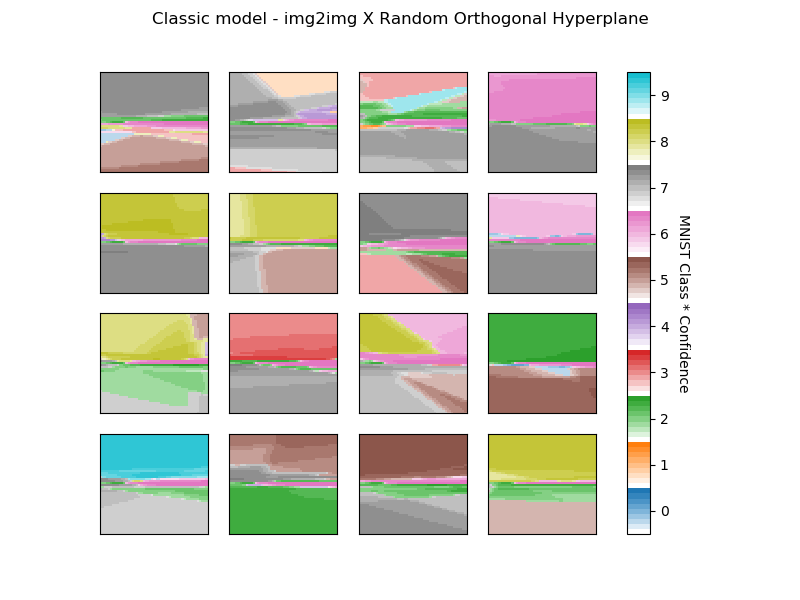

In [34]:
fgnh.plot_MNIST_hyperplanes(classic_model, img, img2, rectangle_factor=1,
                            n_plots=n_plots, grid_size=grid_size, mode=mode,
                            title='Classic model - img2img X Random Orthogonal Hyperplane')

<IPython.core.display.Javascript object>


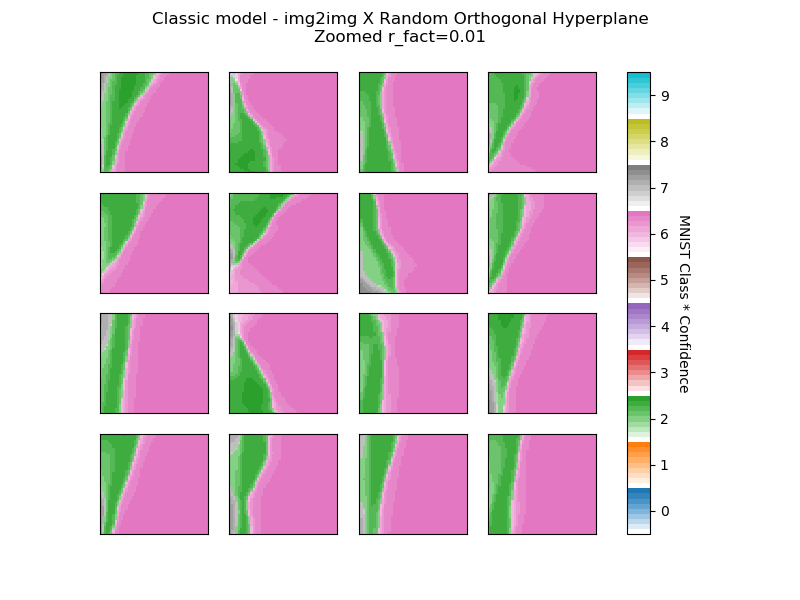

In [35]:
fgnh.plot_MNIST_hyperplanes(classic_model, img, img2, rectangle_factor=0.01,
                            n_plots=n_plots, grid_size=grid_size, mode=mode,
                            title='Classic model - img2img X Random Orthogonal Hyperplane\nZoomed r_fact=0.01')

<IPython.core.display.Javascript object>


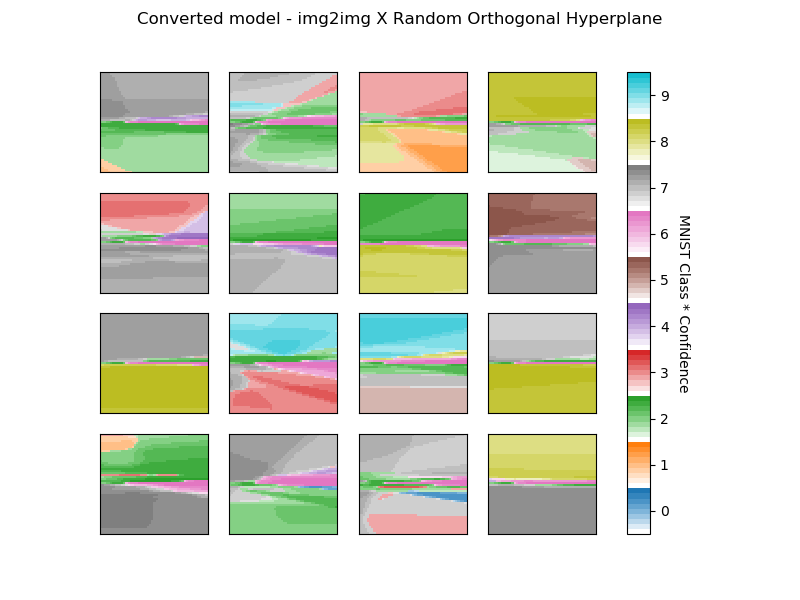

In [36]:
fgnh.plot_MNIST_hyperplanes(conv_fgn_model, img, img2, rectangle_factor=1,
                            n_plots=n_plots, grid_size=grid_size, mode=mode,
                            title='Converted model - img2img X Random Orthogonal Hyperplane')

<IPython.core.display.Javascript object>


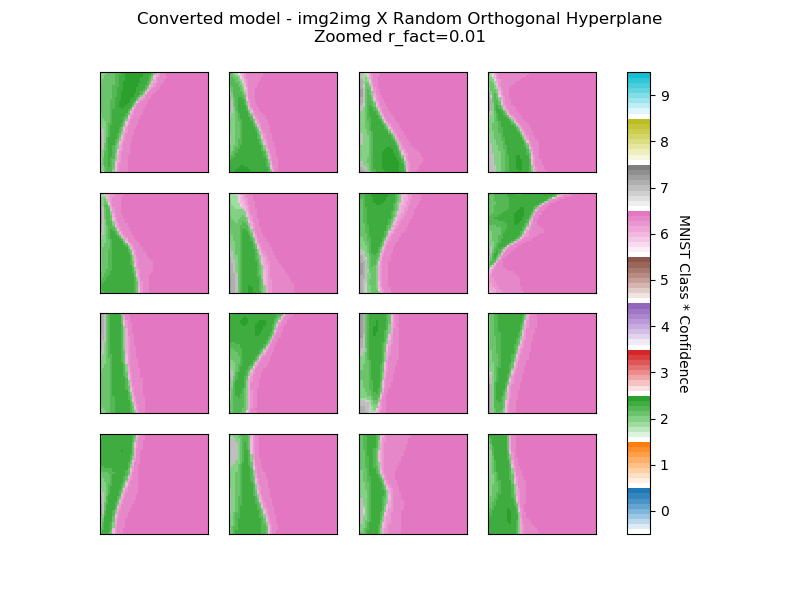

In [37]:
fgnh.plot_MNIST_hyperplanes(conv_fgn_model, img, img2, rectangle_factor=0.01,
                            n_plots=n_plots, grid_size=grid_size, mode=mode,
                            title='Converted model - img2img X Random Orthogonal Hyperplane\nZoomed r_fact=0.01')

<IPython.core.display.Javascript object>


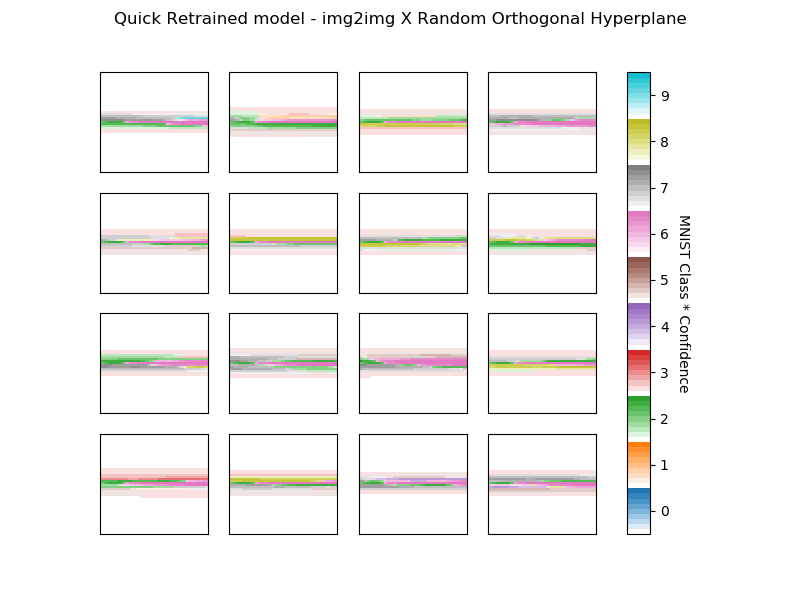

In [38]:
fgnh.plot_MNIST_hyperplanes(ret_quick_fgn_model, img, img2, rectangle_factor=1,
                            n_plots=n_plots, grid_size=grid_size, mode=mode,
                            title='Quick Retrained model - img2img X Random Orthogonal Hyperplane')

<IPython.core.display.Javascript object>


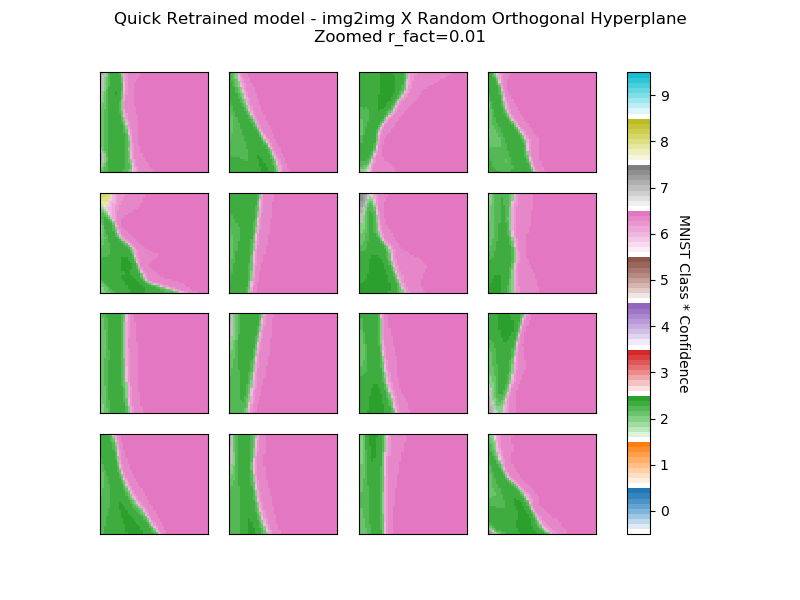

In [39]:
fgnh.plot_MNIST_hyperplanes(ret_quick_fgn_model, img, img2, rectangle_factor=0.01,
                            n_plots=n_plots, grid_size=grid_size, mode=mode,
                            title='Quick Retrained model - img2img X Random Orthogonal Hyperplane\nZoomed r_fact=0.01')

/home/felix/Research/Adversarial Research/FGN---Research/Finite_Gaussian_Network_lib/fgn_helper_lib/plot_MNIST_hyperplanes.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrows=n_plots, ncols=n_plots)


<IPython.core.display.Javascript object>


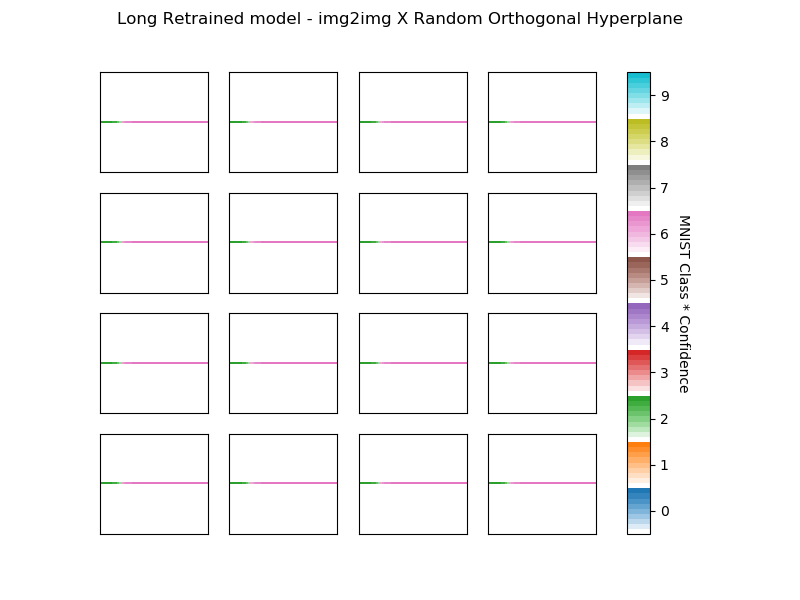

In [40]:
fgnh.plot_MNIST_hyperplanes(ret_long_fgn_model, img, img2, rectangle_factor=1,
                            n_plots=n_plots, grid_size=grid_size, mode=mode,
                            title='Long Retrained model - img2img X Random Orthogonal Hyperplane')

<IPython.core.display.Javascript object>


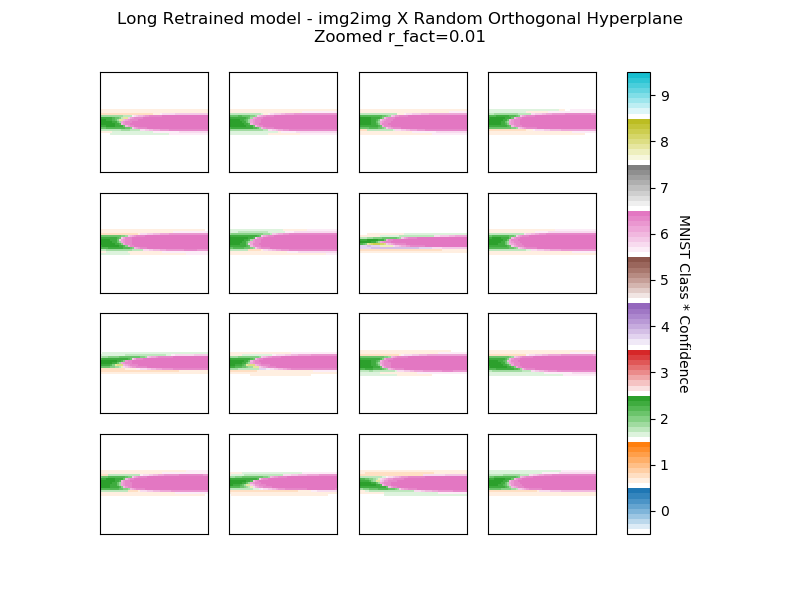

In [41]:
fgnh.plot_MNIST_hyperplanes(ret_long_fgn_model, img, img2, rectangle_factor=0.01,
                            n_plots=n_plots, grid_size=grid_size, mode=mode,
                            title='Long Retrained model - img2img X Random Orthogonal Hyperplane\nZoomed r_fact=0.01')

# 3 - Random Hyperplane

In [42]:
# pick a random direction
random_dir = torch.Tensor(np.reshape(np.array([ np.random.choice([-1,0,1]) for _ in range(28*28)]), (28,28)))

<IPython.core.display.Javascript object>


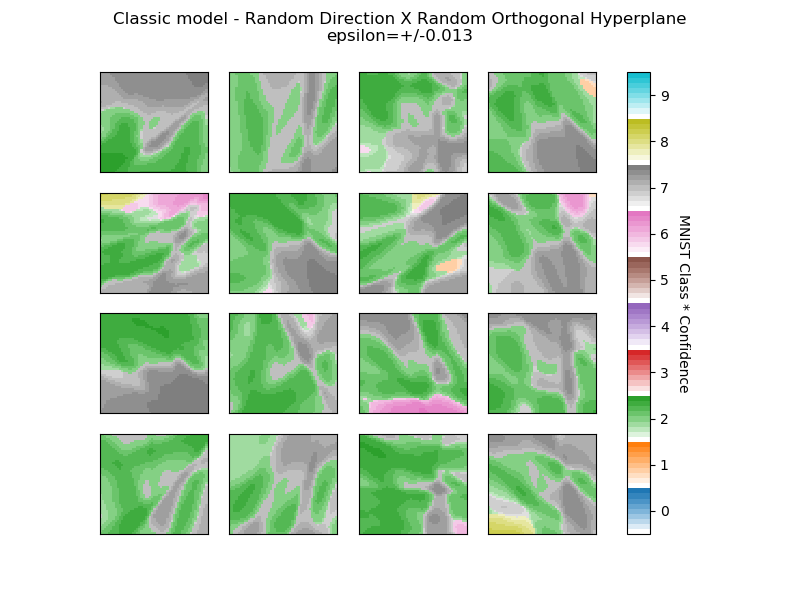

In [43]:
fgnh.plot_MNIST_hyperplanes(classic_model, img-epsilon*random_dir, img+epsilon*random_dir, rectangle_factor=1,
                            n_plots=n_plots, grid_size=grid_size, mode=mode,
                            title='Classic model - Random Direction X Random Orthogonal Hyperplane\nepsilon=+/-{}'.format(np.around(epsilon,4)))

<IPython.core.display.Javascript object>


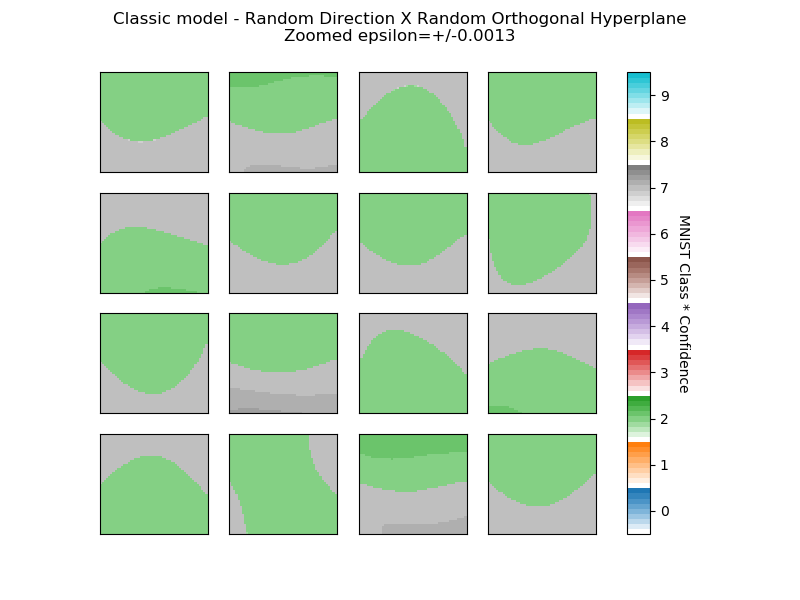

In [44]:
factor = 0.1
fgnh.plot_MNIST_hyperplanes(classic_model, img-epsilon*factor*random_dir, img+epsilon*factor*random_dir, rectangle_factor=1,
                            n_plots=n_plots, grid_size=grid_size, mode=mode,
                            title='Classic model - Random Direction X Random Orthogonal Hyperplane\nZoomed epsilon=+/-{}'.format(np.around(factor*epsilon,4)))

<IPython.core.display.Javascript object>


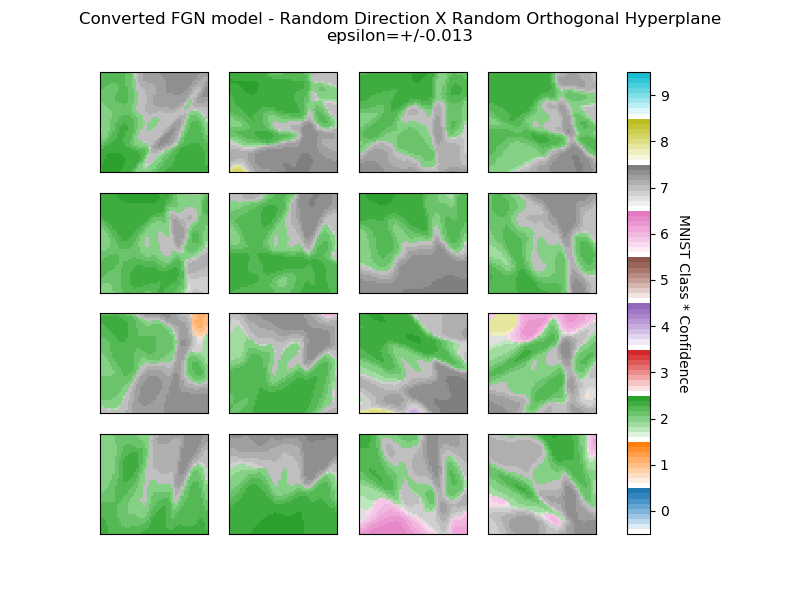

In [45]:
fgnh.plot_MNIST_hyperplanes(conv_fgn_model, img-epsilon*random_dir, img+epsilon*random_dir, rectangle_factor=1,
                            n_plots=n_plots, grid_size=grid_size, mode=mode,
                            title='Converted FGN model - Random Direction X Random Orthogonal Hyperplane\nepsilon=+/-{}'.format(np.around(epsilon,4)))

<IPython.core.display.Javascript object>


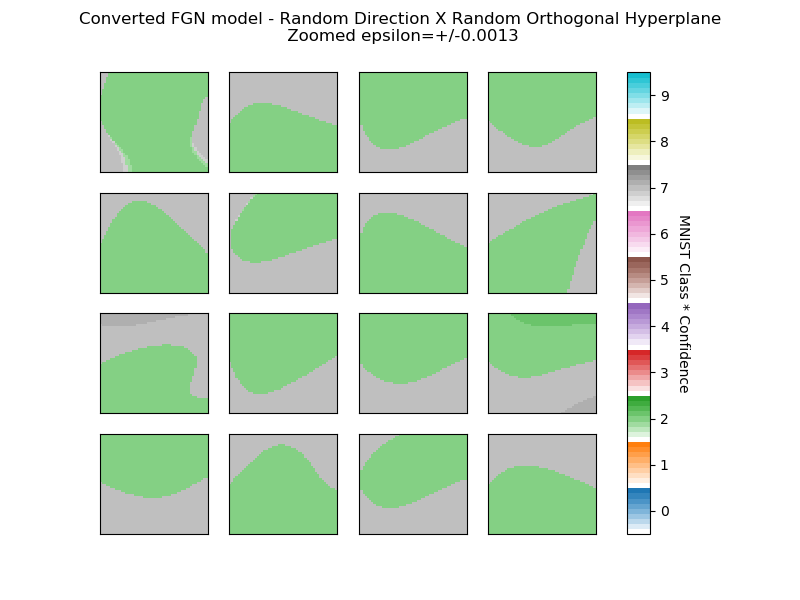

In [46]:
fgnh.plot_MNIST_hyperplanes(conv_fgn_model, img-epsilon*factor*random_dir, img+epsilon*factor*random_dir, rectangle_factor=1,
                            n_plots=n_plots, grid_size=grid_size, mode=mode,
                            title='Converted FGN model - Random Direction X Random Orthogonal Hyperplane\n Zoomed epsilon=+/-{}'.format(np.around(factor*epsilon,4)))

<IPython.core.display.Javascript object>


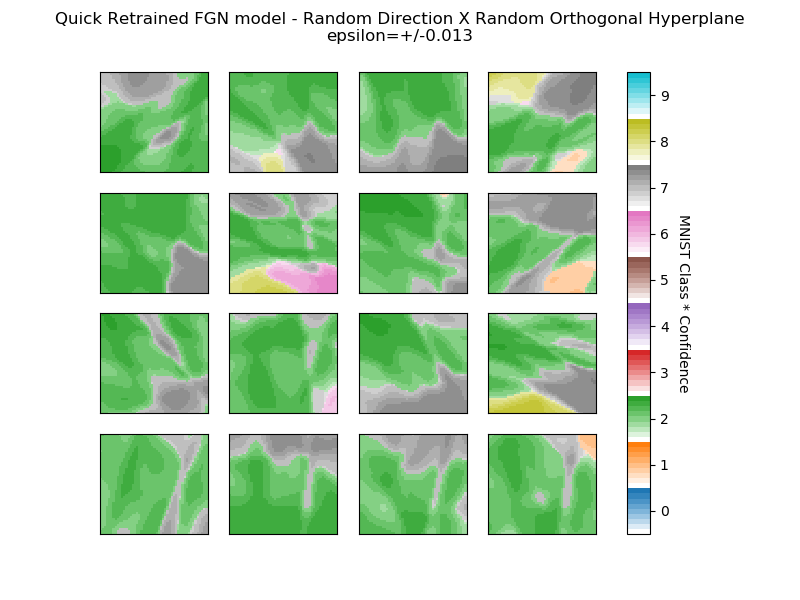

In [47]:
fgnh.plot_MNIST_hyperplanes(ret_quick_fgn_model, img-epsilon*random_dir, img+epsilon*random_dir, rectangle_factor=1,
                            n_plots=n_plots, grid_size=grid_size, mode=mode,
                            title='Quick Retrained FGN model - Random Direction X Random Orthogonal Hyperplane\nepsilon=+/-{}'.format(np.around(epsilon,4)))

<IPython.core.display.Javascript object>


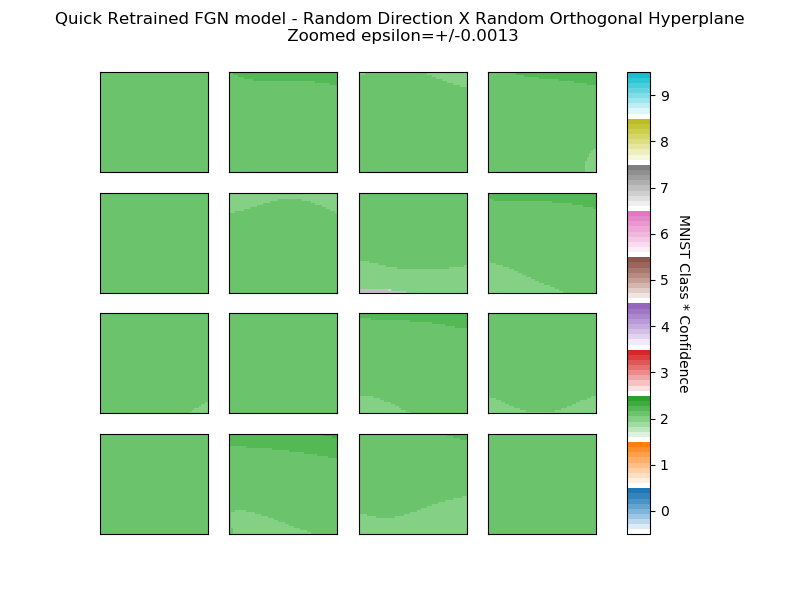

In [48]:
fgnh.plot_MNIST_hyperplanes(ret_quick_fgn_model, img-epsilon*factor*random_dir, img+epsilon*factor*random_dir, rectangle_factor=1,
                            n_plots=n_plots, grid_size=grid_size, mode=mode,
                            title='Quick Retrained FGN model - Random Direction X Random Orthogonal Hyperplane\n Zoomed epsilon=+/-{}'.format(np.around(factor*epsilon,4)))

<IPython.core.display.Javascript object>


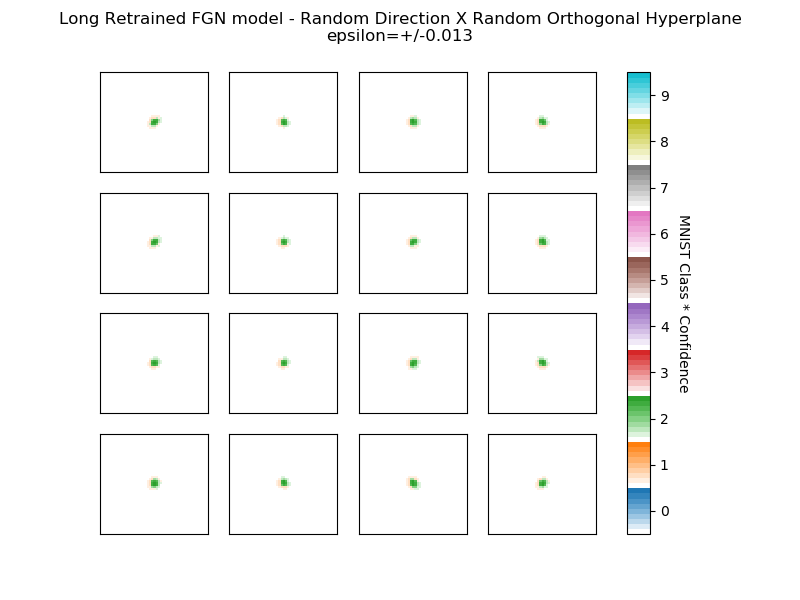

In [49]:
fgnh.plot_MNIST_hyperplanes(ret_long_fgn_model, img-epsilon*random_dir, img+epsilon*random_dir, rectangle_factor=1,
                            n_plots=n_plots, grid_size=grid_size, mode=mode,
                            title='Long Retrained FGN model - Random Direction X Random Orthogonal Hyperplane\nepsilon=+/-{}'.format(np.around(epsilon,4)))

<IPython.core.display.Javascript object>


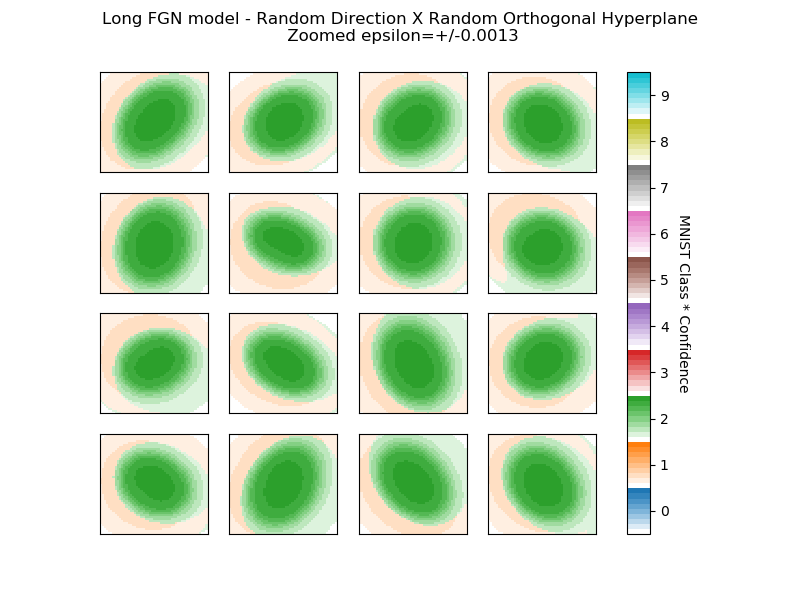

In [50]:
fgnh.plot_MNIST_hyperplanes(ret_long_fgn_model, img-epsilon*factor*random_dir, img+epsilon*factor*random_dir, rectangle_factor=1,
                            n_plots=n_plots, grid_size=grid_size, mode=mode,
                            title='Long FGN model - Random Direction X Random Orthogonal Hyperplane\n Zoomed epsilon=+/-{}'.format(np.around(factor*epsilon,4)))